In [1]:
pip install ucimlrepo

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from ucimlrepo import fetch_ucirepo

# Fetch dataset
online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468)

# Data (as pandas dataframes)
X = online_shoppers_purchasing_intention_dataset.data.features
y = online_shoppers_purchasing_intention_dataset.data.targets

# Metadata
print(online_shoppers_purchasing_intention_dataset.metadata)

# Variable information
print(online_shoppers_purchasing_intention_dataset.variables)


{'uci_id': 468, 'name': 'Online Shoppers Purchasing Intention Dataset', 'repository_url': 'https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/468/data.csv', 'abstract': 'Of the 12,330 sessions in the dataset,\n84.5% (10,422) were negative class samples that did not\nend with shopping, and the rest (1908) were positive class\nsamples ending with shopping.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 12330, 'num_features': 17, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Revenue'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Thu Jan 11 2024', 'dataset_doi': '10.24432/C5F88Q', 'creators': ['C. Sakar', 'Yomi Kastro'], 'intro_paper': {'title': 'Real-time prediction of online shoppers’ purchasing intention using multi

In [3]:
# Data understanding
print("First few rows of the features:")
print(X.head())

print("\nFirst few rows of the target:")
print(y.head())

print("\nData information for features:")
print(X.info())

print("\nData information for target:")
print(y.info())


First few rows of the features:
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10 

In [4]:
# Check for NULL values in features
print("\nCheck for NULL values in features:")
print(X.isnull().sum())

# Check for NULL values in target
print("\nCheck for NULL values in target:")
print(y.isnull().sum())



Check for NULL values in features:
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
dtype: int64

Check for NULL values in target:
Revenue    0
dtype: int64


In [5]:
# Data preprocessing
# Encode categorical variables if necessary
le = LabelEncoder()
if X['Month'].dtype == 'object':
    X.loc[:, 'Month'] = le.fit_transform(X['Month'])
if X['VisitorType'].dtype == 'object':
    X.loc[:, 'VisitorType'] = le.fit_transform(X['VisitorType'])
if X['Weekend'].dtype == 'bool':
    X.loc[:, 'Weekend'] = X['Weekend'].astype(int)
if y.iloc[:, 0].dtype == 'object':  # Convert target to Series
    y = y.iloc[:, 0]
    y = le.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

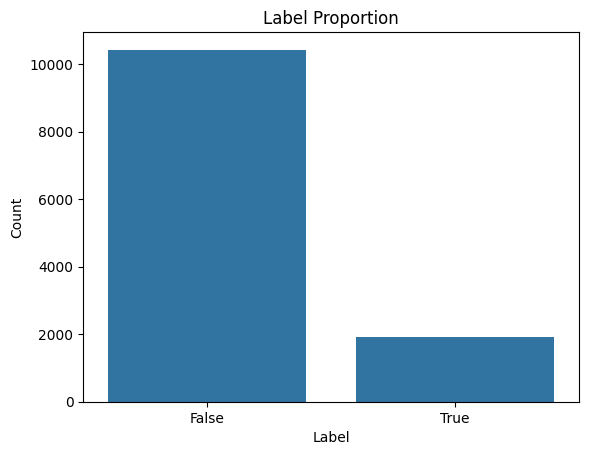


Label counts:
Revenue
False    10422
True      1908
Name: count, dtype: int64


In [6]:
# Ensure y is a Series
if isinstance(y, pd.DataFrame):
    y = y.squeeze()

# Visualize label proportion
sns.countplot(x=y)
plt.title("Label Proportion")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Check if data is imbalanced
print("\nLabel counts:")
print(y.value_counts())

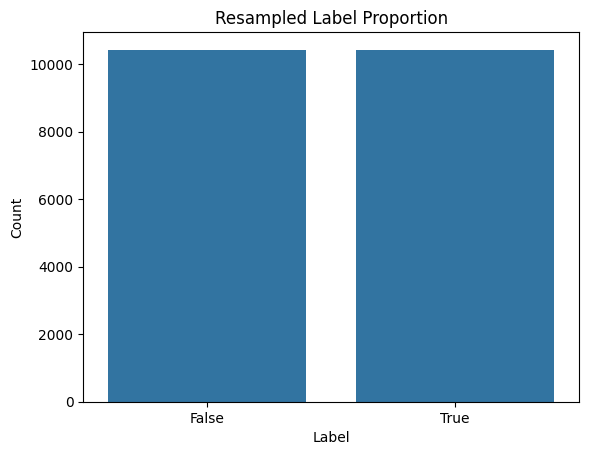

In [7]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualize resampled label proportion
sns.countplot(x=y_resampled)
plt.title("Resampled Label Proportion")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [11]:
# Define the model and hyperparameters
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# K-Fold Cross Validation with GridSearchCV
kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, scoring='f1', n_jobs=-1)

grid_search.fit(X_resampled, y_resampled)
best_rf = grid_search.best_estimator_

print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}



Confusion Matrix:
[[1881  181]
 [  90 2017]]


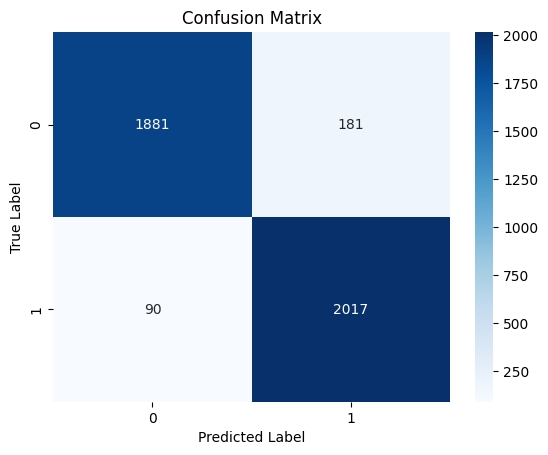


Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.91      0.93      2062
        True       0.92      0.96      0.94      2107

    accuracy                           0.93      4169
   macro avg       0.94      0.93      0.93      4169
weighted avg       0.94      0.93      0.93      4169


Accuracy and F1 Score table:
           Model  Accuracy  F1 Score
0  Random Forest  0.934996   0.93705


In [12]:
# Train and evaluate the best model
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Accuracy and F1 Score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results = pd.DataFrame({
    'Model': ['Random Forest'],
    'Accuracy': [accuracy],
    'F1 Score': [f1]
})

print("\nAccuracy and F1 Score table:")
print(results)